<a href="https://colab.research.google.com/github/gigikenneth/fex/blob/main/ssl3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A self-supervised learning approach where the pretext task is based on a triplet loss formulation.

 In self-supervised learning, the model is trained on a pretext task using unlabeled data, and the learned representations are then used for downstream tasks.

In this code, the self-supervised learning pretext task involves training the SelfSupervisedModel using a triplet loss. The model takes unlabeled images as input, and it learns to embed images into a high-dimensional space such that the distance between the embeddings of similar images (anchor and positive) is minimized, while the distance between the embeddings of dissimilar images (anchor and negative) is maximized.

The TripleLoss class defines the triplet loss function, which computes the Euclidean distances between the anchor, positive, and negative embeddings and calculates the loss based on the margin. The loss is backpropagated through the model, and the optimizer updates the model's parameters to minimize the loss.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


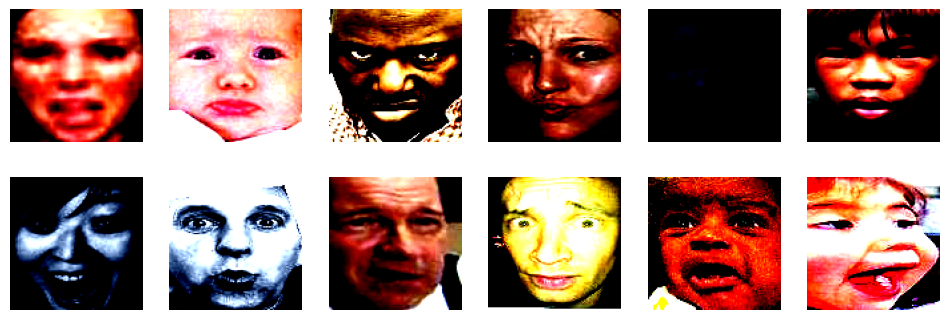

Epoch [1/10], Step [10/124], Loss: 89.5591
Epoch [1/10], Step [20/124], Loss: 67.3970
Epoch [1/10], Step [30/124], Loss: 2.7223
Epoch [1/10], Step [40/124], Loss: 9.5662
Epoch [1/10], Step [50/124], Loss: 24.0568
Epoch [1/10], Step [60/124], Loss: 7.1997
Epoch [1/10], Step [70/124], Loss: 2.5880
Epoch [1/10], Step [80/124], Loss: 12.1227
Epoch [1/10], Step [90/124], Loss: 14.3474
Epoch [1/10], Step [100/124], Loss: 9.5300
Epoch [1/10], Step [110/124], Loss: 3.8637
Epoch [1/10], Step [120/124], Loss: 14.4857
End of Epoch 1. Learning Rate: 0.001
Epoch [2/10], Step [10/124], Loss: 5.4675
Epoch [2/10], Step [20/124], Loss: 12.6593
Epoch [2/10], Step [30/124], Loss: 10.5176
Epoch [2/10], Step [40/124], Loss: 6.7467
Epoch [2/10], Step [50/124], Loss: 2.4338
Epoch [2/10], Step [60/124], Loss: 19.1636
Epoch [2/10], Step [70/124], Loss: 13.3237
Epoch [2/10], Step [80/124], Loss: 13.1050
Epoch [2/10], Step [90/124], Loss: 6.8906
Epoch [2/10], Step [100/124], Loss: 4.1500
Epoch [2/10], Step [110/

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import random

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define your self-supervised learning model architecture
class SelfSupervisedModel(nn.Module):
    def __init__(self, num_classes):
        super(SelfSupervisedModel, self).__init__()
        # Define your model layers here
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(64 * 100 * 100, num_classes)
        self.embeddings = None

    def forward(self, x):
        # Define the forward pass of your model here
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        self.embeddings = self.fc(x)
        return self.embeddings

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
gamma = 0.1  # Learning rate decay factor
step_size = 5  # Number of epochs after which to decay learning rate

# Define your data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image tensors
])

# Set the path to your unlabelled images directory
unlabelled_images_dir = '/content/drive/MyDrive/images'

# Define the custom dataset class for unlabelled images
class UnlabelledDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

# Create the unlabelled dataset
unlabelled_dataset = UnlabelledDataset(unlabelled_images_dir, transform=transform)

# Create a data loader for your unlabelled dataset
unlabelled_dataloader = DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=True)

# Select 12 random images for visualization
random_indices = random.sample(range(len(unlabelled_dataset)), 12)
sample_images = [unlabelled_dataset[idx] for idx in random_indices]

# Display the sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 6, figsize=(12, 4))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_images[i].permute(1, 2, 0))
    ax.axis('off')

plt.show()

# Define your self-supervised learning model
model = SelfSupervisedModel(num_classes=10).to(device)

# Define your loss function (Triple loss)
class TripleLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripleLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute Euclidean distances
        distance_positive = torch.sqrt(torch.sum(torch.pow(anchor - positive, 2), dim=1))
        distance_negative = torch.sqrt(torch.sum(torch.pow(anchor - negative, 2), dim=1))
        # Compute triplet loss
        loss = torch.mean(torch.relu(distance_positive - distance_negative + self.margin))
        return loss

criterion = TripleLoss()

# Get the trainable parameters of the model
parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = list(parameters)  # Convert to a list

# Check if there are trainable parameters
if len(parameters) == 0:
    raise ValueError("No trainable parameters found in the model.")

# Define your optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, images in enumerate(unlabelled_dataloader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Generate placeholder targets (since the images are unlabelled)
        targets = torch.zeros(outputs.size(0), dtype=torch.long).to(device)

        # Compute the self-supervised learning loss (Triple loss)
        embeddings = model.embeddings
        num_samples = embeddings.size(0)

        # Make sure the number of samples is a multiple of 3
        if num_samples % 3 != 0:
            num_samples = num_samples - (num_samples % 3)
            embeddings = embeddings[:num_samples]

        anchor = embeddings[0:num_samples:3]
        positive = embeddings[1:num_samples:3]
        negative = embeddings[2:num_samples:3]

        loss = criterion(anchor, positive, negative)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss after every few iterations
        if (batch_idx+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(unlabelled_dataloader)}], Loss: {loss.item():.4f}')

    # Update the learning rate scheduler
    scheduler.step()

    # Display epoch information
    print(f"End of Epoch {epoch+1}. Learning Rate: {scheduler.get_last_lr()[0]}")

# End of training
print("Training finished.")

# Save the learned representations
torch.save(model.embeddings, 'representations.pth')
